# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [6]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [21]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [25]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [26]:
images.as_numpy_iterator().next()

b'data\\images\\699cace6-3462-11ee-8cae-18473df49f34.jpg'

In [33]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [28]:
images = images.map(load_image)

In [29]:
images.as_numpy_iterator().next()

array([[[76, 73, 80],
        [76, 73, 80],
        [70, 69, 77],
        ...,
        [29, 22, 30],
        [29, 21, 34],
        [31, 23, 36]],

       [[76, 73, 80],
        [75, 72, 79],
        [71, 70, 78],
        ...,
        [33, 26, 34],
        [34, 26, 39],
        [33, 25, 38]],

       [[72, 71, 76],
        [71, 70, 75],
        [70, 69, 75],
        ...,
        [35, 30, 37],
        [37, 29, 42],
        [34, 26, 39]],

       ...,

       [[27, 23, 24],
        [26, 22, 23],
        [25, 21, 22],
        ...,
        [29, 23, 33],
        [30, 23, 31],
        [29, 22, 30]],

       [[27, 21, 23],
        [25, 19, 21],
        [24, 20, 21],
        ...,
        [30, 22, 33],
        [32, 22, 33],
        [31, 21, 32]],

       [[27, 21, 23],
        [25, 19, 21],
        [24, 20, 21],
        ...,
        [29, 21, 32],
        [31, 21, 32],
        [32, 22, 33]]], dtype=uint8)

In [30]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [31]:
image_generator = images.batch(4).as_numpy_iterator()

In [34]:
plot_images = image_generator.next()

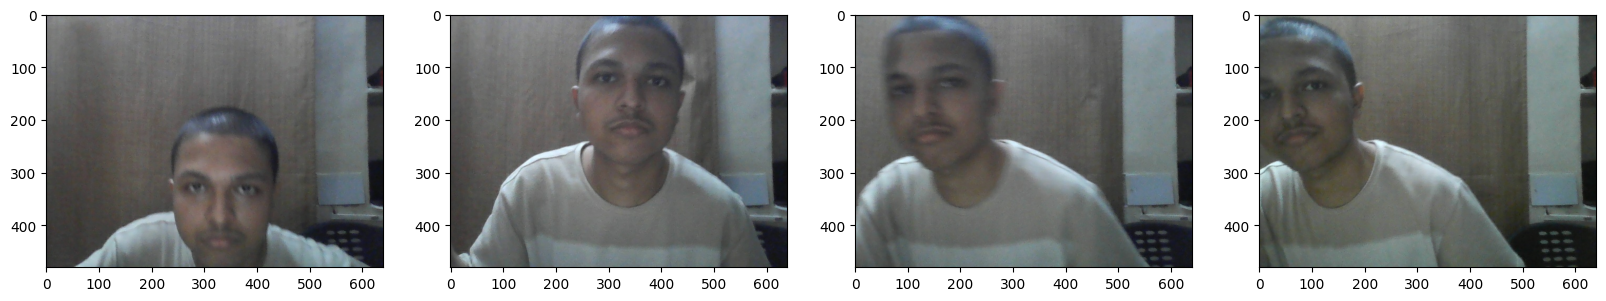

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [36]:
90*.7 # 63 to train

62.99999999999999

In [37]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [3]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

NameError: name 'os' is not defined

# 4. Apply Image Augmentation on Images and Labels using Albumentations

In [7]:
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

### 4.1 Setup Albumentations Transform Pipeline

In [10]:
import albumentations as alb

In [11]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [16]:
img = cv2.imread(os.path.join('data','train', 'images','6a8cb3ee-3462-11ee-92e2-18473df49f34.jpg'))

In [17]:
with open(os.path.join('data', 'train', 'labels', '6a8cb3ee-3462-11ee-92e2-18473df49f34.json'), 'r') as f:
    label = json.load(f)

In [18]:
label['shapes'][0]['points']

[[232.98342541436466, 51.6022099447514],
 [477.18232044198896, 412.92817679558016]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [19]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [20]:
coords

[232.98342541436466, 51.6022099447514, 477.18232044198896, 412.92817679558016]

In [21]:
coords = list(np.divide(coords, [640,480,640,480]))

In [22]:
coords

[0.36403660220994477,
 0.10750460405156542,
 0.7455973756906078,
 0.860267034990792]

### 4.4 Apply Augmentations and View Results

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [24]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [25]:
augmented['bboxes'][0][2:]

(0.7222590546347452, 0.936439533456108)

In [26]:
augmented['bboxes']

[(0.17959484346224674,
  0.1334929404542663,
  0.7222590546347452,
  0.936439533456108)]

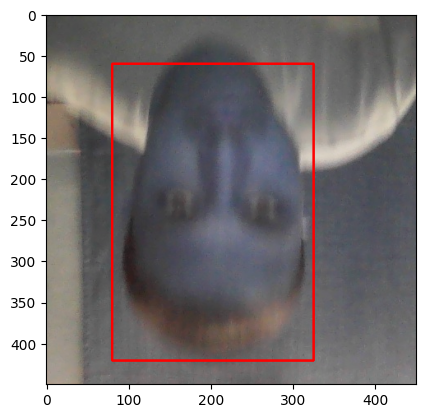

In [27]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [28]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.3459081491712707, 0.4113720073664825, 0.3459081491712707, 0.4113720073664825, 'face'].
y_max is less than or equal to y_min for bbox [0.0644854972375691, 0.008517495395948475, 0.2633157803867413, 0.0, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [34]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [35]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [37]:
train_images.as_numpy_iterator().next()

array([[[0.26421568, 0.26421568, 0.3004902 ],
        [0.26127452, 0.26256126, 0.29068628],
        [0.2526348 , 0.2526348 , 0.28890932],
        ...,
        [0.5088848 , 0.51280636, 0.5206495 ],
        [0.5115809 , 0.5115809 , 0.5115809 ],
        [0.51476717, 0.51476717, 0.51476717]],

       [[0.25735295, 0.25882354, 0.2857843 ],
        [0.25882354, 0.2627451 , 0.27058825],
        [0.26354167, 0.26795343, 0.27432597],
        ...,
        [0.50851715, 0.5124387 , 0.52028185],
        [0.52867645, 0.5296569 , 0.52916664],
        [0.5167892 , 0.5167892 , 0.50894606]],

       [[0.25949755, 0.25949755, 0.30300245],
        [0.25980392, 0.2637255 , 0.28229168],
        [0.2627451 , 0.26666668, 0.28137255],
        ...,
        [0.48688725, 0.49473038, 0.4908088 ],
        [0.48958334, 0.49742648, 0.48664215],
        [0.49191177, 0.49485293, 0.48553923]],

       ...,

       [[0.07481617, 0.09442402, 0.11795343],
        [0.0754902 , 0.08627451, 0.10588235],
        [0.08284314, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1437, 0.    , 0.748 , 0.691 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 780, 780, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [47]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.2788, 0.1881, 0.9565],
        [0.    , 0.    , 0.484 , 0.692 ],
        [0.3145, 0.532 , 0.6445, 0.948 ],
        [0.8237, 0.2424, 1.    , 0.969 ],
        [0.3367, 0.6577, 0.78  , 1.    ],
        [0.2659, 0.9824, 0.601 , 1.    ],
        [0.1128, 0.282 , 0.557 , 0.848 ],
        [0.464 , 0.4805, 0.8877, 1.    ]], dtype=float16))

### 7.3 View Images and Annotations

In [48]:
data_samples = train.as_numpy_iterator()

In [49]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


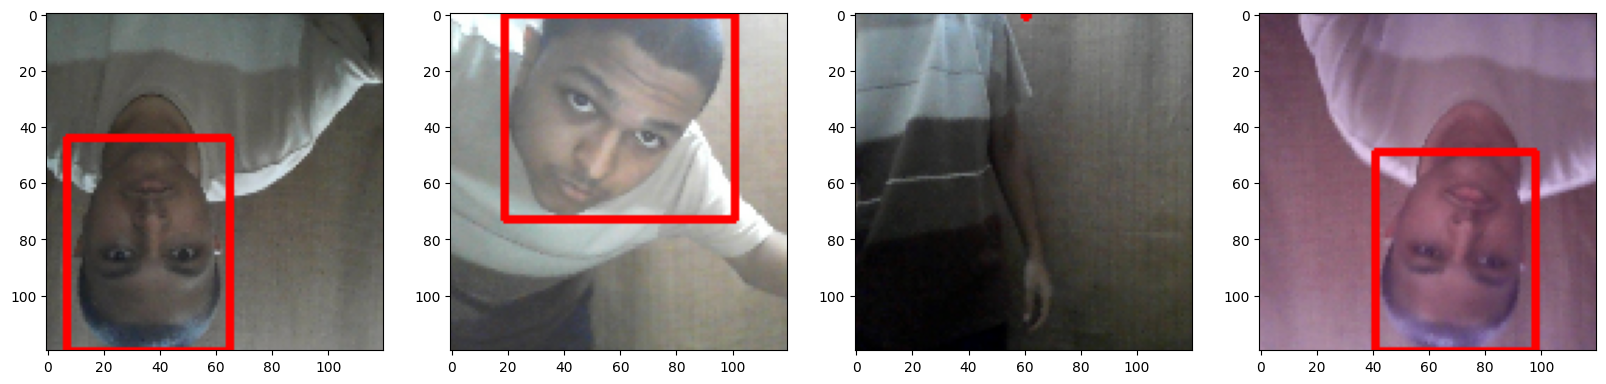

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [52]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 123s 2us/step


In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [54]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 682ms/step


In [60]:
classes, coords

(array([[0.46895602],
        [0.4938567 ],
        [0.481658  ],
        [0.44642004],
        [0.5263393 ],
        [0.5029076 ],
        [0.45322025],
        [0.4546797 ]], dtype=float32),
 array([[0.5664889 , 0.493124  , 0.47508883, 0.5587623 ],
        [0.57554746, 0.50071645, 0.46352214, 0.56801504],
        [0.568013  , 0.5340409 , 0.45452398, 0.4937416 ],
        [0.5878031 , 0.490747  , 0.4792734 , 0.61879146],
        [0.55688673, 0.49925613, 0.47231147, 0.42545635],
        [0.511558  , 0.50389737, 0.43203673, 0.5110505 ],
        [0.5136122 , 0.49970302, 0.4421245 , 0.5361477 ],
        [0.5194111 , 0.5128757 , 0.4706146 , 0.48603398]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [64]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [76]:
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)
opt = keras_legacy_optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


### 9.2 Create Localization Loss and Classification Loss

In [65]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [66]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [67]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7031264>

In [68]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.75174034>

In [69]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7031264>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [70]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [71]:
model = FaceTracker(facetracker)

In [77]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [78]:
logdir='logs'

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 709s 2s/step - total_loss: 0.4962 - class_loss: 0.1049 - regress_loss: 0.4437 - val_total_loss: 0.1134 - val_class_loss: 0.1136 - val_regress_loss: 0.0567
Epoch 2/10
465/465 [==============================] - 719s 2s/step - total_loss: 0.1715 - class_loss: 0.0444 - regress_loss: 0.1493 - val_total_loss: 0.4245 - val_class_loss: 0.1015 - val_regress_loss: 0.3737
Epoch 3/10
465/465 [==============================] - 713s 2s/step - total_loss: 0.1217 - class_loss: 0.0331 - regress_loss: 0.1052 - val_total_loss: 0.0184 - val_class_loss: 4.1233e-05 - val_regress_loss: 0.0184
Epoch 4/10
465/465 [==============================] - 713s 2s/step - total_loss: 0.0818 - class_loss: 0.0248 - regress_loss: 0.0694 - val_total_loss: 0.4309 - val_class_loss: 0.0042 - val_regress_loss: 0.4288
Epoch 5/10
465/465 [==============================] - 740s 2s/step - total_loss: 0.0711 - class_loss: 0.0253 - regress_loss: 0.0585 - val_total_loss: 0.0511 - v

### 10.3 Plot Performance

In [81]:
hist.history

{'total_loss': [0.41344934701919556,
  0.05243408679962158,
  0.033623188734054565,
  0.022238336503505707,
  0.3393191993236542,
  0.020042041316628456,
  0.017684735357761383,
  0.0032972097396850586,
  0.009848914109170437,
  0.014401583932340145],
 'class_loss': [0.08195553719997406,
  0.0008280259207822382,
  0.005817072931677103,
  0.00025725795421749353,
  0.306137353181839,
  0.0016758593264967203,
  0.004984396044164896,
  1.041608993546106e-05,
  3.527295484673232e-05,
  0.00022723237634636462],
 'regress_loss': [0.37247157096862793,
  0.05202007293701172,
  0.030714653432369232,
  0.022109707817435265,
  0.18625052273273468,
  0.019204111769795418,
  0.015192536637187004,
  0.003292001783847809,
  0.009831277653574944,
  0.014287968166172504],
 'val_total_loss': [0.1134462058544159,
  0.42446333169937134,
  0.018416233360767365,
  0.4308863878250122,
  0.05107241868972778,
  0.010925918817520142,
  0.020828982815146446,
  1.0214996337890625,
  0.6569342613220215,
  0.5857306

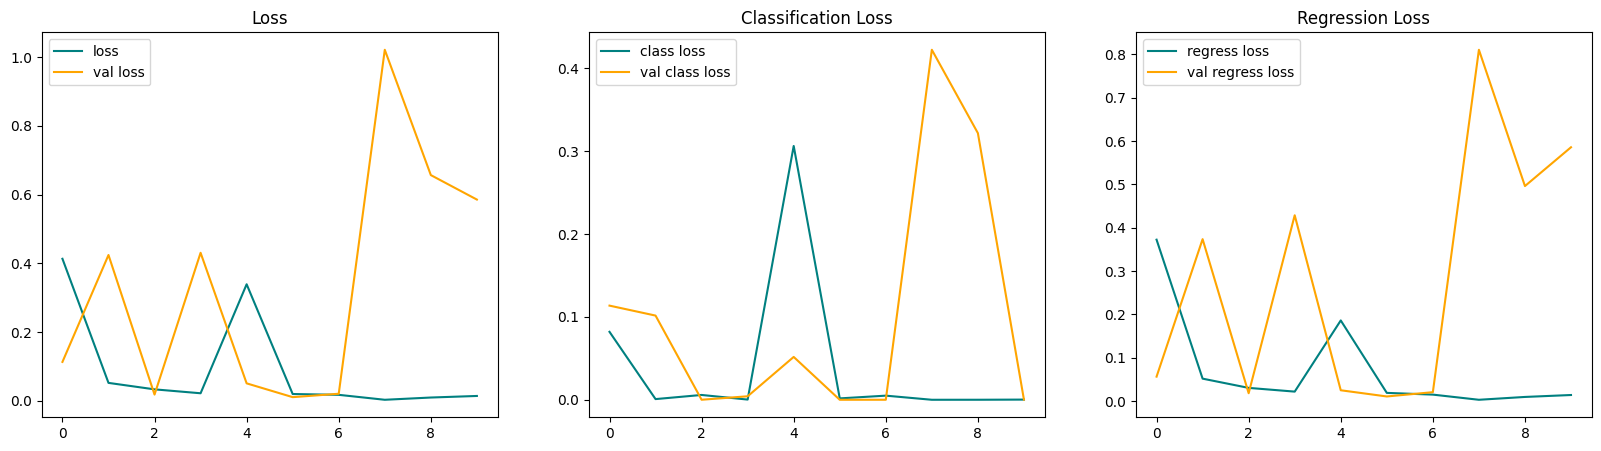

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [83]:
test_data = test.as_numpy_iterator()

In [84]:
test_sample = test_data.next()

In [85]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 288ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


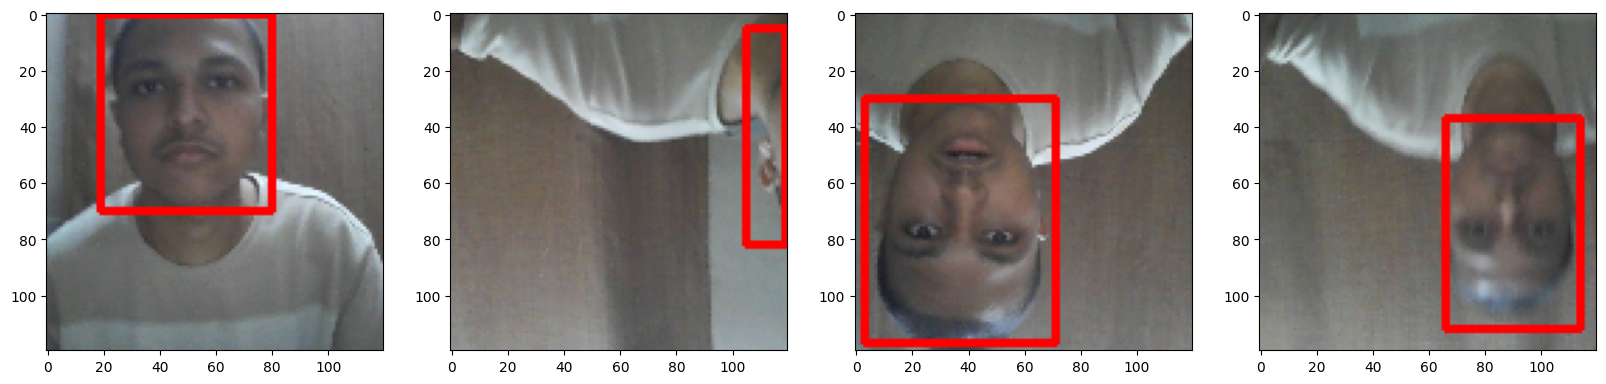

In [86]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [87]:
from tensorflow.keras.models import load_model

In [88]:
facetracker.save('facetracker.h5')

C:\Users\Ajay\cnn\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 230ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 379ms/step
